In [2]:
try:
    # Check if PyTorch Geometric is installed:
    import torch_geometric
except ImportError:
    # If PyTorch Geometric is not installed, install it.
    !pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
    !pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
    !pip install -q torch-geometric

ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/cli/main.py", line 71, in main
    return command.main(cmd_args)
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/cli/base_command.py", line 104, in main
    return self._main(args)
  File "/usr/lib/python3.8/contextlib.py", line 120, in __exit__
    next(self.gen)
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/cli/command_context.py", line 22, in main_context
    yield
  File "/usr/lib/python3.8/contextlib.py", line 525, in __exit__
    raise exc_details[1]
  File "/usr/lib/python3.8/contextlib.py", line 131, in __exit__
    self.gen.throw(type, value, traceback)
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/utils/temp_dir.py", line 75, in tempdir_registry
    yield _tempdir_registry
  File "/usr/lib/python3.8/contextlib.py", line 510, in __exit_

# Graph Neural Networks 2: Design Space

In [ ]:
import copy
from typing import Callable, Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import torch
import torch_geometric.transforms as T
from torch import Tensor
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import Sequential
from torch_geometric.utils import accuracy
from typing_extensions import Literal, TypedDict

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = Planetoid("/tmp/Cora", name="Cora", transform=T.NormalizeFeatures())
data = dataset[0].to(device)

In [ ]:
LossFn = Callable[[Tensor, Tensor], Tensor]
Stage = Literal["train", "val", "test"]


def train_step(
    model: torch.nn.Module, data: Data, optimizer: torch.optim.Optimizer, loss_fn: LossFn
) -> Tuple[float, float]:
    model.train()
    optimizer.zero_grad()
    mask = data.train_mask
    logits = model(data.x, data.edge_index)[mask]
    preds = logits.argmax(dim=1)
    y = data.y[mask]
    loss = loss_fn(logits, y)
    acc = accuracy(preds, y)
    loss.backward()
    optimizer.step()
    return loss.item(), acc


@torch.no_grad()
def eval_step(model: torch.nn.Module, data: Data, loss_fn: LossFn, stage: Stage) -> Tuple[float, float]:
    model.eval()
    mask = getattr(data, f"{stage}_mask")
    logits = model(data.x, data.edge_index)[mask]
    preds = logits.argmax(dim=1)
    y = data.y[mask]
    loss = loss_fn(logits, y)
    acc = accuracy(preds, y)
    return loss.item(), acc

In [ ]:
class HistoryDict(TypedDict):
    loss: List[float]
    acc: List[float]
    val_loss: List[float]
    val_acc: List[float]


def train(
    model: torch.nn.Module,
    data: Data,
    optimizer: torch.optim.Optimizer,
    loss_fn: LossFn = torch.nn.CrossEntropyLoss(),
    max_epochs: int = 200,
    early_stopping: int = 10,
    print_interval: int = 20,
    verbose: bool = True,
) -> HistoryDict:
    history = {"loss": [], "val_loss": [], "acc": [], "val_acc": []}
    min_loss = float("inf")
    early_stopping_counter = 0
    for epoch in range(max_epochs):
        loss, acc = train_step(model, data, optimizer, loss_fn)
        val_loss, val_acc = eval_step(model, data, loss_fn, "val")
        history["loss"].append(loss)
        history["acc"].append(acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        # Early stopping
        if val_loss < min_loss:
            min_loss = val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter == early_stopping:
            if verbose:
                print("\nEarly stopping...")

            break

        if verbose and epoch % print_interval == 0:
            print(f"\nEpoch: {epoch}\n----------")
            print(f"Train loss: {loss:.4f} | Train acc: {acc:.4f}")
            print(f"  Val loss: {val_loss:.4f} |   Val acc: {val_acc:.4f}")

    test_loss, test_acc = eval_step(model, data, loss_fn, "test")
    if verbose:
        print(f"\nEpoch: {epoch}\n----------")
        print(f"Train loss: {loss:.4f} | Train acc: {acc:.4f}")
        print(f"  Val loss: {val_loss:.4f} |   Val acc: {val_acc:.4f}")
        print(f" Test loss: {test_loss:.4f} |  Test acc: {test_acc:.4f}")

    return history

In [ ]:
def plot_history(history: HistoryDict, title: str, font_size: Optional[int] = 14) -> None:
    plt.suptitle(title, fontsize=font_size)
    ax1 = plt.subplot(121)
    ax1.set_title("Loss")
    ax1.plot(history["loss"], label="train")
    ax1.plot(history["val_loss"], label="val")
    plt.xlabel("Epoch")
    ax1.legend()

    ax2 = plt.subplot(122)
    ax2.set_title("Accuracy")
    ax2.plot(history["acc"], label="train")
    ax2.plot(history["val_acc"], label="val")
    plt.xlabel("Epoch")
    ax2.legend()

In [ ]:
# Hyper parameters that we will not change during the experiments:
SEED = 42
HIDDEN_CHANNELS = 16
LEARNING_RATE = 0.01
WEIGHT_DECAY = 5e-4


torch.manual_seed(SEED)

# Classical GNN Layers: GCN

In [ ]:
from torch_geometric.nn import GCN


Epoch: 0
----------
Train loss: 2.7734 | Train acc: 0.0357
  Val loss: 2.7648 |   Val acc: 0.2460

Epoch: 20
----------
Train loss: 2.5632 | Train acc: 0.8429
  Val loss: 2.6157 |   Val acc: 0.5860

Epoch: 40
----------
Train loss: 2.4065 | Train acc: 0.8429
  Val loss: 2.5039 |   Val acc: 0.5860

Epoch: 60
----------
Train loss: 2.2918 | Train acc: 0.8357
  Val loss: 2.4212 |   Val acc: 0.5860

Epoch: 80
----------
Train loss: 2.2052 | Train acc: 0.8357
  Val loss: 2.3581 |   Val acc: 0.5940

Epoch: 100
----------
Train loss: 2.1385 | Train acc: 0.8357
  Val loss: 2.3090 |   Val acc: 0.5980

Epoch: 120
----------
Train loss: 2.0863 | Train acc: 0.8286
  Val loss: 2.2701 |   Val acc: 0.6020

Epoch: 140
----------
Train loss: 2.0451 | Train acc: 0.8286
  Val loss: 2.2391 |   Val acc: 0.6100

Epoch: 160
----------
Train loss: 2.0122 | Train acc: 0.8286
  Val loss: 2.2141 |   Val acc: 0.6140

Epoch: 180
----------
Train loss: 1.9858 | Train acc: 0.8286
  Val loss: 2.1938 |   Val acc: 0.6

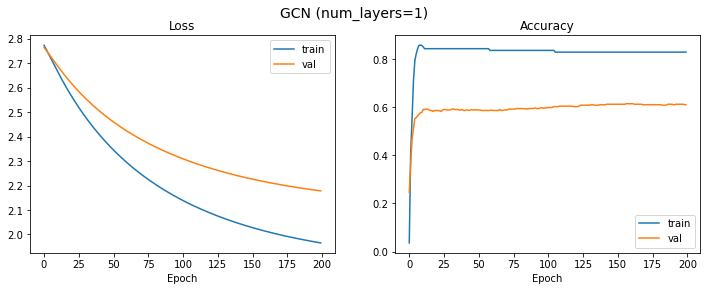

In [ ]:
NUM_LAYERS = 1


model = GCN(dataset.num_node_features, HIDDEN_CHANNELS, NUM_LAYERS).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer)

plt.figure(figsize=(12, 4))
plot_history(history, f"GCN (num_layers={NUM_LAYERS})")

# Classical GNN Layers: GraphSAGE

- 그래프의 노드 각각에 대한 embedding을 직접 학습하게 되면, 새로운 노드가 추가되었을 때 그 새로운 노드에 대한 embedding을 추론할 수 없음.
- GraphSage는 노드 임베딩이 아닌 aggregation function을 학습
- Algorithm
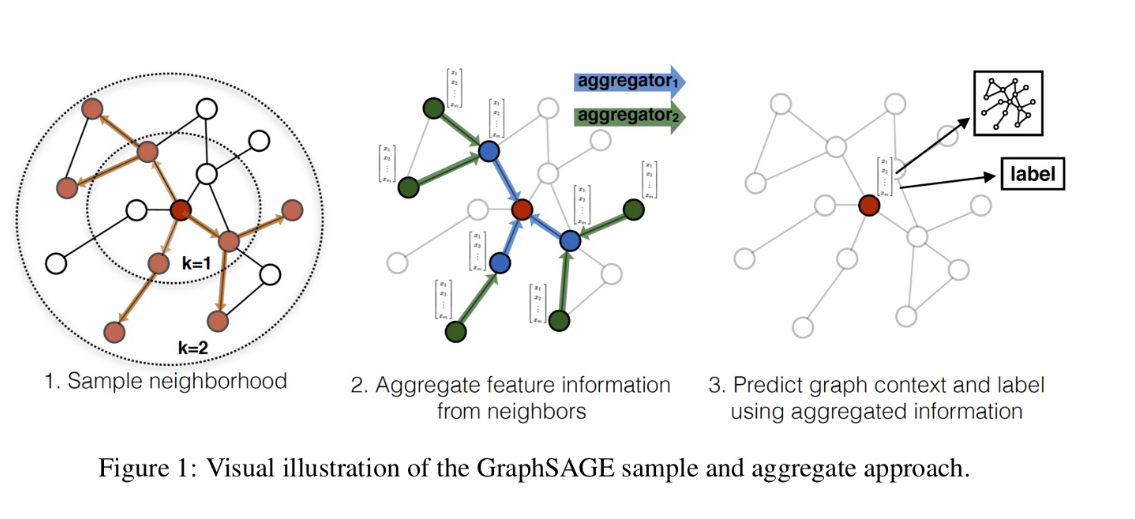

-  batch를 샘플링하는 방법과 node neighborhood에 대한 정의가 필요

In [ ]:
from torch_geometric.nn import GraphSAGE


Epoch: 0
----------
Train loss: 2.7750 | Train acc: 0.0214
  Val loss: 2.7686 |   Val acc: 0.0920

Epoch: 20
----------
Train loss: 2.5319 | Train acc: 0.5714
  Val loss: 2.6704 |   Val acc: 0.3740

Epoch: 40
----------
Train loss: 2.3480 | Train acc: 0.5714
  Val loss: 2.5984 |   Val acc: 0.3840

Epoch: 60
----------
Train loss: 2.2219 | Train acc: 0.5714
  Val loss: 2.5511 |   Val acc: 0.3860

Epoch: 80
----------
Train loss: 2.1204 | Train acc: 0.5714
  Val loss: 2.4998 |   Val acc: 0.3900

Epoch: 100
----------
Train loss: 1.8489 | Train acc: 0.8000
  Val loss: 2.2974 |   Val acc: 0.3880

Epoch: 120
----------
Train loss: 1.6902 | Train acc: 0.8571
  Val loss: 2.1878 |   Val acc: 0.5300

Epoch: 140
----------
Train loss: 1.6038 | Train acc: 0.8571
  Val loss: 2.1285 |   Val acc: 0.5700

Epoch: 160
----------
Train loss: 1.5492 | Train acc: 0.8571
  Val loss: 2.0884 |   Val acc: 0.5880

Epoch: 180
----------
Train loss: 1.5104 | Train acc: 0.8571
  Val loss: 2.0589 |   Val acc: 0.6

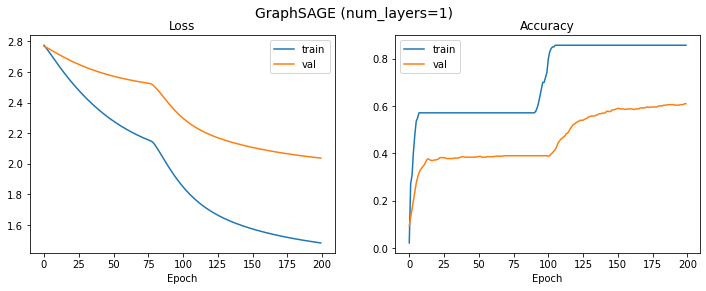

In [ ]:
NUM_LAYERS = 1


model = GraphSAGE(dataset.num_node_features, HIDDEN_CHANNELS, NUM_LAYERS).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer)

plt.figure(figsize=(12, 4))
plot_history(history, f"GraphSAGE (num_layers={NUM_LAYERS})")

# GraphSAGE Neighbor Aggregation

**[Neighborhood Aggregation / Message Passing scheme]**

- irregular한 도메인들에 convolution operator을 일반화하는 것
- aggregation 종류 : `mean`, `pool`, `LSTM`

**Aggregation function**

- `mean aggregation` captures the distribution (or proportions) of elements
- `max aggregation` proves to be advantageous to identify representative elements
- `sum aggregation` enables the learning of structural graph properties
- using `multiple aggregations` and `learnable aggregations` can potentially provide substantial improvements


Epoch: 0
----------
Train loss: 2.7736 | Train acc: 0.0214
  Val loss: 2.7573 |   Val acc: 0.3200

Epoch: 20
----------
Train loss: 1.8874 | Train acc: 1.0000
  Val loss: 2.3090 |   Val acc: 0.6560

Epoch: 40
----------
Train loss: 1.3280 | Train acc: 1.0000
  Val loss: 1.9780 |   Val acc: 0.7240

Epoch: 60
----------
Train loss: 1.0216 | Train acc: 1.0000
  Val loss: 1.7855 |   Val acc: 0.7460

Epoch: 80
----------
Train loss: 0.8539 | Train acc: 1.0000
  Val loss: 1.6690 |   Val acc: 0.7500

Epoch: 100
----------
Train loss: 0.7529 | Train acc: 1.0000
  Val loss: 1.5905 |   Val acc: 0.7480

Epoch: 120
----------
Train loss: 0.6852 | Train acc: 1.0000
  Val loss: 1.5327 |   Val acc: 0.7420

Epoch: 140
----------
Train loss: 0.6363 | Train acc: 1.0000
  Val loss: 1.4878 |   Val acc: 0.7400

Epoch: 160
----------
Train loss: 0.5995 | Train acc: 1.0000
  Val loss: 1.4520 |   Val acc: 0.7400

Epoch: 180
----------
Train loss: 0.5710 | Train acc: 1.0000
  Val loss: 1.4226 |   Val acc: 0.7

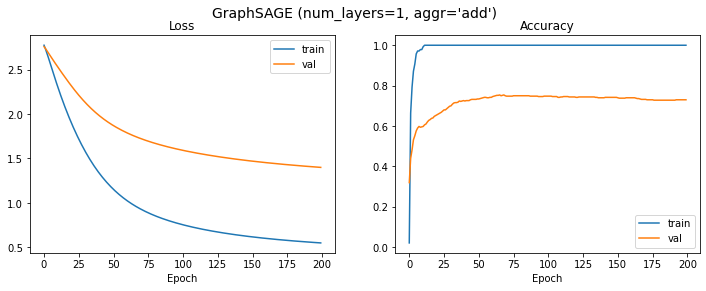

In [ ]:
NUM_LAYERS = 1
AGGR = "add"


model = GraphSAGE(dataset.num_node_features, HIDDEN_CHANNELS, NUM_LAYERS, aggr=AGGR).to(device) ## aggregation 방식을 add로 설정해 GraphSAGE 모델 정의
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer)

plt.figure(figsize=(12, 4))
plot_history(history, f"GraphSAGE (num_layers={NUM_LAYERS}, aggr='{AGGR}')")

# GraphSAGE: L2 Normalization

- L2 normalization을 진행하면, 모든 벡터는 길이가 1인 벡터가 된다.
- 기존 임베딩 벡터의 크기나 길이가 많이 다른 경우에는 정규화를 하고 나면 성능이 향상된다.


Epoch: 0
----------
Train loss: 2.7404 | Train acc: 0.1286
  Val loss: 2.5988 |   Val acc: 0.2720

Epoch: 20
----------
Train loss: 2.0094 | Train acc: 0.8643
  Val loss: 2.2770 |   Val acc: 0.6820

Early stopping...

Epoch: 26
----------
Train loss: 2.0034 | Train acc: 0.8643
  Val loss: 2.2681 |   Val acc: 0.6800
 Test loss: 2.2764 |  Test acc: 0.6550


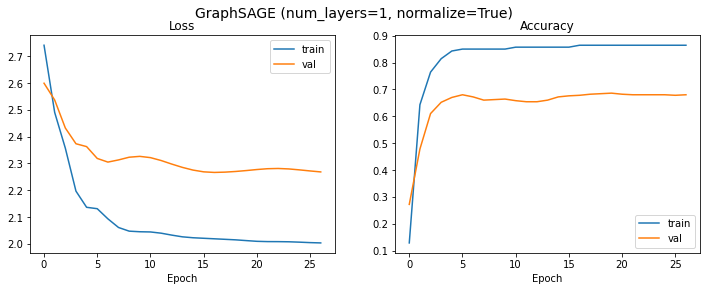

In [ ]:
NUM_LAYERS = 1
NORMALIZE = True


model = GraphSAGE(dataset.num_node_features, HIDDEN_CHANNELS, NUM_LAYERS, normalize=NORMALIZE).to(device) ## normalize=True라고 함으로써 모든 layer에 정규화 진행
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer)

plt.figure(figsize=(12, 4))
plot_history(history, f"GraphSAGE (num_layers={NUM_LAYERS}, normalize={NORMALIZE})")

# Classical GNN Layers: GAT

**[GAT]**
- 이웃 노드에 대한 중요도를 나타낸 attention weight를 추가한 GNN 모델
- attention weight는 중요한 부분에 포커스를 맞추고 나머지는 fade out시켜 중요한 노드에 컴퓨팅 파워를 쏟도록 함.
- attention weight는 노드마다 다르기 때문에 attention weight는 훈련을 통해 학습됨.
- [GAT 참고사이트](https://data-newbie.tistory.com/819)

In [ ]:
from torch_geometric.nn import GAT


Epoch: 0
----------
Train loss: 2.7724 | Train acc: 0.0643
  Val loss: 2.7633 |   Val acc: 0.3100

Epoch: 20
----------
Train loss: 2.5600 | Train acc: 0.8500
  Val loss: 2.5816 |   Val acc: 0.7080

Epoch: 40
----------
Train loss: 2.3990 | Train acc: 0.8500
  Val loss: 2.4405 |   Val acc: 0.7100

Epoch: 60
----------
Train loss: 2.2694 | Train acc: 0.8500
  Val loss: 2.3250 |   Val acc: 0.6980

Epoch: 80
----------
Train loss: 2.1243 | Train acc: 0.8357
  Val loss: 2.2149 |   Val acc: 0.6500

Epoch: 100
----------
Train loss: 1.9532 | Train acc: 0.8286
  Val loss: 2.1198 |   Val acc: 0.6200

Epoch: 120
----------
Train loss: 1.7408 | Train acc: 0.8714
  Val loss: 2.0289 |   Val acc: 0.5800

Epoch: 140
----------
Train loss: 1.5748 | Train acc: 0.9286
  Val loss: 1.9617 |   Val acc: 0.5580

Epoch: 160
----------
Train loss: 1.4381 | Train acc: 0.9500
  Val loss: 1.9038 |   Val acc: 0.5560

Epoch: 180
----------
Train loss: 1.3277 | Train acc: 0.9714
  Val loss: 1.8543 |   Val acc: 0.5

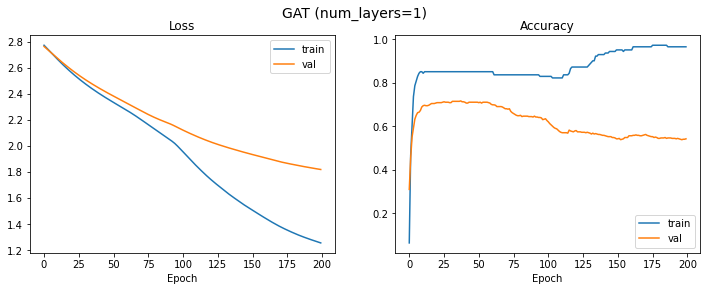

In [ ]:
NUM_LAYERS = 1


model = GAT(dataset.num_node_features, HIDDEN_CHANNELS, NUM_LAYERS).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer)

plt.figure(figsize=(12, 4))
plot_history(history, f"GAT (num_layers={NUM_LAYERS})")

# Attention Mechanism

## Multi-head attention


Epoch: 0
----------
Train loss: 2.7729 | Train acc: 0.0500
  Val loss: 2.7650 |   Val acc: 0.3100

Epoch: 20
----------
Train loss: 2.5319 | Train acc: 0.9929
  Val loss: 2.5790 |   Val acc: 0.7160

Epoch: 40
----------
Train loss: 2.3382 | Train acc: 0.9929
  Val loss: 2.4306 |   Val acc: 0.7220

Epoch: 60
----------
Train loss: 2.1845 | Train acc: 0.9929
  Val loss: 2.3104 |   Val acc: 0.7340

Epoch: 80
----------
Train loss: 2.0243 | Train acc: 0.9786
  Val loss: 2.1931 |   Val acc: 0.7120

Epoch: 100
----------
Train loss: 1.8603 | Train acc: 0.9643
  Val loss: 2.0978 |   Val acc: 0.6800

Epoch: 120
----------
Train loss: 1.7194 | Train acc: 0.9429
  Val loss: 2.0246 |   Val acc: 0.6240

Epoch: 140
----------
Train loss: 1.5831 | Train acc: 0.9500
  Val loss: 1.9623 |   Val acc: 0.5960

Epoch: 160
----------
Train loss: 1.4742 | Train acc: 0.9571
  Val loss: 1.9103 |   Val acc: 0.5820

Epoch: 180
----------
Train loss: 1.3837 | Train acc: 0.9571
  Val loss: 1.8696 |   Val acc: 0.5

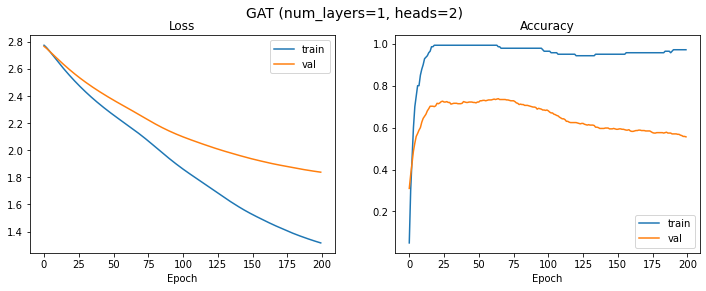

In [ ]:
NUM_LAYERS = 1
HEADS = 2


model = GAT(dataset.num_node_features, HIDDEN_CHANNELS, NUM_LAYERS, heads=HEADS).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer)

plt.figure(figsize=(12, 4))
plot_history(history, f"GAT (num_layers={NUM_LAYERS}, heads={HEADS})")

# GNN Layer in Practice

## Batch Normalization

In [ ]:
from torch_geometric.nn import BatchNorm


Epoch: 0
----------
Train loss: 2.8215 | Train acc: 0.0500
  Val loss: 2.7664 |   Val acc: 0.2520

Epoch: 20
----------
Train loss: 0.1938 | Train acc: 0.9643
  Val loss: 2.6375 |   Val acc: 0.5320

Epoch: 40
----------
Train loss: 0.1061 | Train acc: 0.9857
  Val loss: 2.4820 |   Val acc: 0.5320

Epoch: 60
----------
Train loss: 0.0754 | Train acc: 0.9857
  Val loss: 2.2161 |   Val acc: 0.5220

Epoch: 80
----------
Train loss: 0.0701 | Train acc: 0.9857
  Val loss: 1.9596 |   Val acc: 0.5200

Epoch: 100
----------
Train loss: 0.0680 | Train acc: 0.9857
  Val loss: 1.8989 |   Val acc: 0.5100

Early stopping...

Epoch: 115
----------
Train loss: 0.0669 | Train acc: 0.9857
  Val loss: 1.8970 |   Val acc: 0.4960
 Test loss: 1.8746 |  Test acc: 0.5010


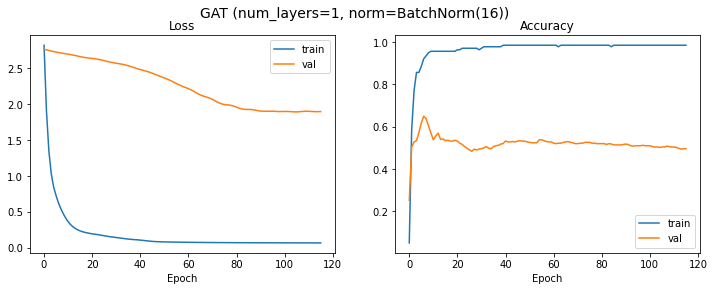

In [ ]:
NUM_LAYERS = 1
NORM = BatchNorm(HIDDEN_CHANNELS)


model = GAT(dataset.num_node_features, HIDDEN_CHANNELS, NUM_LAYERS, norm=NORM).to(device) ## hidden layer에 대해 batch normalization 진행
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer)

plt.figure(figsize=(12, 4))
plot_history(history, f"GAT (num_layers={NUM_LAYERS}, norm={NORM})")

## Dropout


Epoch: 0
----------
Train loss: 2.7720 | Train acc: 0.0929
  Val loss: 2.7642 |   Val acc: 0.2540

Epoch: 20
----------
Train loss: 2.5630 | Train acc: 0.5000
  Val loss: 2.6126 |   Val acc: 0.6740

Epoch: 40
----------
Train loss: 2.5075 | Train acc: 0.4000
  Val loss: 2.4931 |   Val acc: 0.7100

Epoch: 60
----------
Train loss: 2.3844 | Train acc: 0.4714
  Val loss: 2.4137 |   Val acc: 0.7040

Epoch: 80
----------
Train loss: 2.1822 | Train acc: 0.5286
  Val loss: 2.3423 |   Val acc: 0.7120

Epoch: 100
----------
Train loss: 2.3630 | Train acc: 0.4000
  Val loss: 2.2945 |   Val acc: 0.7200

Epoch: 120
----------
Train loss: 2.2037 | Train acc: 0.4857
  Val loss: 2.2732 |   Val acc: 0.6940

Epoch: 140
----------
Train loss: 2.2712 | Train acc: 0.4286
  Val loss: 2.2653 |   Val acc: 0.6800

Epoch: 160
----------
Train loss: 2.2218 | Train acc: 0.4000
  Val loss: 2.2453 |   Val acc: 0.6900

Epoch: 180
----------
Train loss: 2.0955 | Train acc: 0.4786
  Val loss: 2.2187 |   Val acc: 0.6

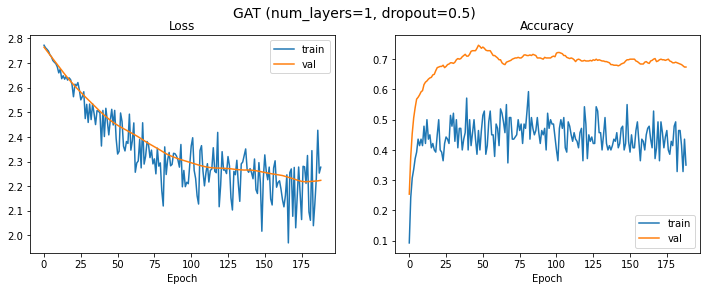

In [ ]:
NUM_LAYERS = 1
DROPOUT = 0.5


model = GAT(dataset.num_node_features, HIDDEN_CHANNELS, NUM_LAYERS, dropout=DROPOUT).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer)

plt.figure(figsize=(12, 4))
plot_history(history, f"GAT (num_layers={NUM_LAYERS}, dropout={DROPOUT})")

## Activation (Non-linearity)


Epoch: 0
----------
Train loss: 3.2302 | Train acc: 0.0429
  Val loss: 2.7699 |   Val acc: 0.2120

Epoch: 20
----------
Train loss: 1.7660 | Train acc: 0.4571
  Val loss: 2.6532 |   Val acc: 0.7140

Epoch: 40
----------
Train loss: 1.5384 | Train acc: 0.5143
  Val loss: 2.4506 |   Val acc: 0.6960

Epoch: 60
----------
Train loss: 1.5260 | Train acc: 0.5714
  Val loss: 2.1379 |   Val acc: 0.6620

Epoch: 80
----------
Train loss: 1.4657 | Train acc: 0.5857
  Val loss: 1.8320 |   Val acc: 0.6460

Epoch: 100
----------
Train loss: 1.3538 | Train acc: 0.6143
  Val loss: 1.7559 |   Val acc: 0.6240

Early stopping...

Epoch: 120
----------
Train loss: 1.5165 | Train acc: 0.5429
  Val loss: 1.7466 |   Val acc: 0.6200
 Test loss: 1.6924 |  Test acc: 0.6470


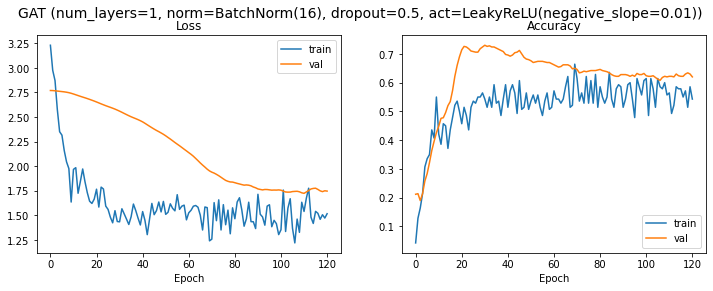

In [ ]:
NUM_LAYERS = 1
NORM = BatchNorm(HIDDEN_CHANNELS)
DROPOUT = 0.5
ACT = torch.nn.LeakyReLU()


model = GAT(dataset.num_node_features, HIDDEN_CHANNELS, NUM_LAYERS, norm=NORM, dropout=DROPOUT, act=ACT).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer)

plt.figure(figsize=(12, 4))
plot_history(history, f"GAT (num_layers={NUM_LAYERS}, norm={NORM}, dropout={DROPOUT}, act={ACT})")

# Stacking GNN Layers


Epoch: 0
----------
Train loss: 2.7724 | Train acc: 0.0357
  Val loss: 2.7604 |   Val acc: 0.2920

Epoch: 20
----------
Train loss: 2.3275 | Train acc: 0.2429
  Val loss: 2.3018 |   Val acc: 0.3220

Epoch: 40
----------
Train loss: 1.9140 | Train acc: 0.8071
  Val loss: 1.9974 |   Val acc: 0.5760

Epoch: 60
----------
Train loss: 1.4394 | Train acc: 0.8071
  Val loss: 1.6424 |   Val acc: 0.6600

Epoch: 80
----------
Train loss: 1.0074 | Train acc: 0.8214
  Val loss: 1.4197 |   Val acc: 0.6400

Epoch: 100
----------
Train loss: 0.7762 | Train acc: 0.8429
  Val loss: 1.3541 |   Val acc: 0.6160

Early stopping...

Epoch: 107
----------
Train loss: 0.7186 | Train acc: 0.8500
  Val loss: 1.3733 |   Val acc: 0.6020
 Test loss: 1.2889 |  Test acc: 0.6450


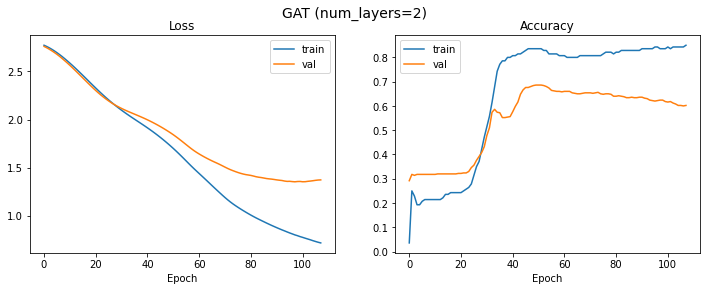

In [ ]:
NUM_LAYERS = 2


model = GAT(dataset.num_node_features, HIDDEN_CHANNELS, NUM_LAYERS).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer)

plt.figure(figsize=(12, 4))
plot_history(history, f"GAT (num_layers={NUM_LAYERS})")

# Expressive Power for Shallow GNNs

In [ ]:
class PrePostProc(torch.nn.Module):
    def __init__(
        self,
        model: torch.nn.Module,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        num_classes: int,
        num_pre_layers: int = 0,
        num_post_layers: int = 0,
        act: Callable[[Tensor], Tensor] = torch.nn.ReLU(inplace=True),
    ) -> None:
        super().__init__()

        self.model = model
        preproc = []
        postproc = []
        if num_pre_layers:
            preproc.append(torch.nn.Linear(in_channels, hidden_channels))
            preproc.append(act)

        for idx in range(num_pre_layers - 1):
            preproc.append(torch.nn.Linear(hidden_channels, hidden_channels))
            preproc.append(act)

        for idx in range(num_post_layers - 1):
            postproc.append(torch.nn.Linear(out_channels, out_channels))
            postproc.append(act)

        if num_post_layers:
            postproc.append(torch.nn.Linear(out_channels, num_classes))

        self.preproc = torch.nn.Sequential(*preproc)
        self.postproc = torch.nn.Sequential(*postproc)

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = self.preproc(x)
        x = self.model(x, edge_index)
        x = self.postproc(x)
        return x


Epoch: 0
----------
Train loss: 1.9697 | Train acc: 0.1429
  Val loss: 1.9469 |   Val acc: 0.1220

Early stopping...

Epoch: 14
----------
Train loss: 1.9463 | Train acc: 0.1429
  Val loss: 1.9497 |   Val acc: 0.0580
 Test loss: 1.9502 |  Test acc: 0.0640


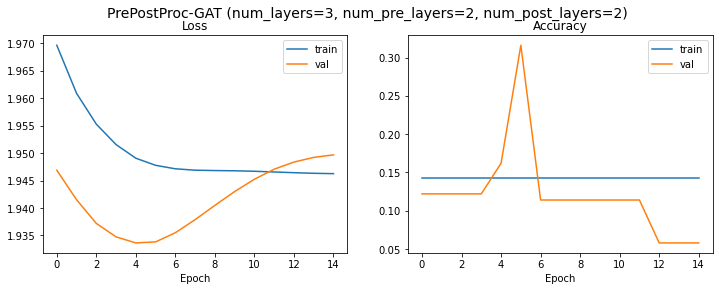

In [ ]:
NUM_LAYERS = 3
NUM_PRE_LAYERS = 2
NUM_POST_LAYERS = 2

model = PrePostProc(
    model=GAT(HIDDEN_CHANNELS, HIDDEN_CHANNELS, NUM_LAYERS, out_channels=HIDDEN_CHANNELS),
    in_channels=dataset.num_node_features,
    hidden_channels=HIDDEN_CHANNELS,
    out_channels=HIDDEN_CHANNELS,
    num_classes=dataset.num_classes,
    num_pre_layers=NUM_PRE_LAYERS,
    num_post_layers=NUM_POST_LAYERS,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer)

plt.figure(figsize=(12, 4))
plot_history(
    history,
    f"PrePostProc-GAT (num_layers={NUM_LAYERS}, num_pre_layers={NUM_PRE_LAYERS}, num_post_layers={NUM_POST_LAYERS})",
)

# Design GNN Layer Connectivity

In [ ]:
from torch_geometric.nn import GCNConv

In [ ]:
class GCNConvBlock(torch.nn.Module):
    def __init__(
        self,
        in_channels: int,
        act: Optional[Callable[[Tensor], Tensor]] = torch.nn.ReLU(inplace=True),
        norm: Optional[torch.nn.Module] = None,
        normalize: bool = True,
        add_skip: bool = False,
    ) -> None:
        super().__init__()
        self.conv = GCNConv(in_channels, in_channels, normalize=normalize)
        self.norm = copy.deepcopy(norm)
        self.act = act
        self.add_skip = add_skip

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        out = self.conv(x, edge_index)
        if self.norm is not None:
            out = self.norm(out)

        if self.add_skip:
            out += x

        if self.act is not None:
            out = self.act(out)

        return out

# Example: GCN with Skip Connections

In [ ]:
class GCNSkip1(torch.nn.Module):
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        num_layers: int,
        out_channels: int,
        dropout: float = 0.0,
        act: Optional[Callable[[Tensor], Tensor]] = torch.nn.ReLU(inplace=True),
        norm: Optional[torch.nn.Module] = None,
        normalize: bool = True,
    ):
        super().__init__()
        self.linear1 = torch.nn.Linear(in_channels, hidden_channels)
        skip_blocks = []
        for _ in range(num_layers):
            skip_blocks.append(
                (
                    GCNConvBlock(hidden_channels, act=act, norm=norm, normalize=normalize, add_skip=True),
                    "x, edge_index -> x",
                )
            )

        self.skip_blocks = Sequential("x, edge_index", modules=skip_blocks)
        self.linear2 = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = self.linear1(x)
        x = self.skip_blocks(x, edge_index)
        x = self.linear2(x)
        return x


Epoch: 0
----------
Train loss: 1.9540 | Train acc: 0.1429
  Val loss: 1.9612 |   Val acc: 0.0720

Epoch: 20
----------
Train loss: 0.9127 | Train acc: 0.8571
  Val loss: 1.4018 |   Val acc: 0.5400

Early stopping...

Epoch: 39
----------
Train loss: 0.0125 | Train acc: 1.0000
  Val loss: 1.3628 |   Val acc: 0.7320
 Test loss: 1.2193 |  Test acc: 0.7230


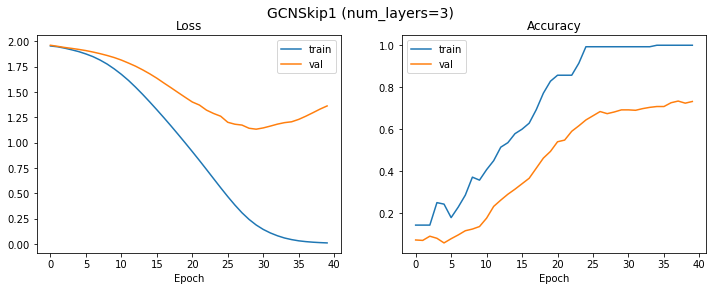

In [ ]:
NUM_LAYERS = 3


model = GCNSkip1(dataset.num_node_features, HIDDEN_CHANNELS, NUM_LAYERS, dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer)

plt.figure(figsize=(12, 4))
plot_history(history, f"GCNSkip1 (num_layers={NUM_LAYERS})")

# Other Option of Skip Connections

In [ ]:
class GCNSkip2(torch.nn.Module):
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        num_layers: int,
        out_channels: int,
        dropout: float = 0.0,
        act: Optional[Callable[[Tensor], Tensor]] = torch.nn.ReLU(inplace=True),
        norm: Optional[torch.nn.Module] = None,
        normalize: bool = True,
    ):
        super().__init__()
        self.num_layers = num_layers
        self.linear1 = torch.nn.Linear(in_channels, hidden_channels)
        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            self.convs.append((GCNConvBlock(hidden_channels, act=act, norm=norm, normalize=normalize)))

        self.linear2 = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = self.linear1(x)
        outs = [x]
        for idx in range(self.num_layers):
            outs.append(self.convs[idx](outs[-1], edge_index))

        x = torch.mean(torch.stack(outs), axis=0)
        x = self.linear2(x)
        return x


Epoch: 0
----------
Train loss: 1.9565 | Train acc: 0.1429
  Val loss: 1.9376 |   Val acc: 0.0580

Early stopping...

Epoch: 10
----------
Train loss: 1.9103 | Train acc: 0.7214
  Val loss: 1.9404 |   Val acc: 0.2180
 Test loss: 1.9399 |  Test acc: 0.2140


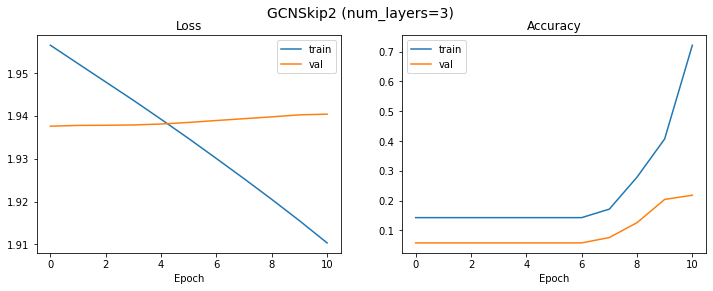

In [ ]:
NUM_LAYERS = 3


model = GCNSkip2(dataset.num_node_features, HIDDEN_CHANNELS, NUM_LAYERS, dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer)

plt.figure(figsize=(12, 4))
plot_history(history, f"GCNSkip2 (num_layers={NUM_LAYERS})")